In [ ]:
import pandas as pd
import pickle
from utils.visualization import plot_sensitivity_analysis
from utils.evaluation import calculate_profit_curve

# 1. Load the Test Data (The "Final Exam")
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').iloc[:, 0]

# 2. Load the Champion Model
model_path = '../models/churn_model_v1.pkl'
with open(model_path, 'rb') as file:
    model = pickle.load(file)

print("✅ Data and Champion Model loaded successfully!")

✅ Data and Champion Model loaded successfully!


In [8]:
# Generate "Risk Scores" (Probabilities)
# predict_proba returns [Prob_Loyal, Prob_Churn]
# We only want column [1] (Prob_Churn)
y_probs = model.predict_proba(X_test)[:, 1]

# Quick check: Show the first 5 risk scores
print("Sample Risk Scores:\n", y_probs[:5])

Sample Risk Scores:
 [0.25655095 0.77761244 0.33361204 0.61203445 0.22316622]


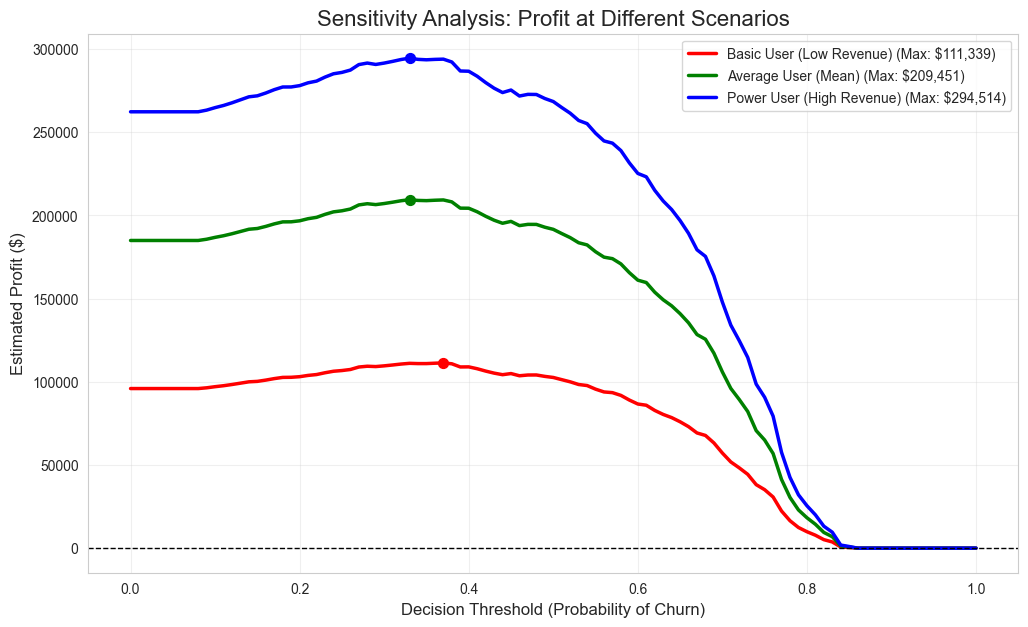

In [9]:
# 1. Define your Scenarios
scenarios = [
    {
        'name': 'Basic User (Low Revenue)', 
        'clv': 852,   # Based on 25th percentile ($35.50 * 24)
        'cost': 45,   # $35.50 + $10
        'rate': 0.5, 
        'color': 'red'
    },
    {
        'name': 'Average User (Mean)',      
        'clv': 1554,  # Based on Mean ($64.76 * 24)
        'cost': 75,   # $65 + $10
        'rate': 0.5, 
        'color': 'green' # <-- This is our most likely scenario
    },
    {
        'name': 'Power User (High Revenue)',
        'clv': 2156,  # Based on 75th percentile ($89.85 * 24)
        'cost': 100,  # $90 + $10
        'rate': 0.5, 
        'color': 'blue'
    }
]

# 2. Plot
plot_sensitivity_analysis(scenarios, y_probs, y_test)

# 7. Business Evaluation & Financial Impact Analysis

The ultimate goal of this project is not just to predict churn, but to **prevent it profitably**. A model with high accuracy is useless if the cost of intervention exceeds the revenue saved.

In this section, we translate our model's technical performance (Recall, Precision) into **estimated financial value (ROI)**.

## A. Defining Business Scenarios
To ensure our profit estimates are realistic, we derived three distinct customer personas directly from the dataset's `MonthlyCharges` statistics (Quartiles). This allows us to perform a **Sensitivity Analysis**—testing how our model performs across different customer segments.

| Scenario | Persona Description | Monthly Charge | Est. CLV (24 Mos) | Intervention Cost |
| :--- | :--- | :--- | :--- | :--- |
| **Basic User** | **25th Percentile:** Budget-conscious customers with minimal services. | **$35.50** | **$852** | **$45** |
| **Average User** | **Mean:** The typical customer with a standard service bundle. | **$64.76** | **$1,554** | **$75** |
| **Power User** | **75th Percentile:** High-value customers with multiple lines/services. | **$89.85** | **$2,156** | **$100** |

**Assumptions:**
* **CLV (Customer Lifetime Value):** We assume a saved customer stays for an additional **24 months**.
* **Intervention Cost:** The cost to retain a customer is calculated as **1 month of free service + $10 admin fee**.
* **Success Rate:** We conservatively assume that our retention offer saves **50%** of the targeted churners.

---

## B. Profit Curve Analysis
The "Profit Curve" visualization (above) reveals the optimal strategy for each customer segment.

### 1. The "Power User" Opportunity (Blue Line)
* **Max Potential Profit:** **~$294,500**
* **Analysis:** This segment is the primary driver of ROI. Because their Lifetime Value ($2,156) is so high compared to the cost of saving them ($100), the model can afford to be aggressive.
* **Strategic Recommendation:** We should prioritize this segment above all others. Even if the model produces some False Alarms (predicting churn when they are actually loyal), the cost of the discount is negligible compared to the risk of losing a $2,000+ customer.

### 2. The "Average User" Baseline (Green Line)
* **Max Potential Profit:** **~$209,400**
* **Analysis:** This represents the core of our business. The model performs robustly here, generating significant profit with a balanced threshold.

### 3. The "Basic User" Risk (Red Line)
* **Max Potential Profit:** **~$111,300**
* **Analysis:** The profit curve is much flatter and lower. The margin for error is thin.
* **Strategic Recommendation:** We must be cautious with this segment. "Spray and pray" marketing tactics will destroy margins here. We should only target Basic Users who have a **very high probability** of churning (Risk Score > 0.60) to avoid wasting money on low-value accounts.

## C. Final Recommendation
Based on this analysis, we propose a **Tiered Retention Strategy**:

1.  **Tier 1 (High Value):** Auto-trigger aggressive retention offers (e.g., 1 Month Free) for any "Power User" with a Churn Risk > **0.35**.
2.  **Tier 2 (Standard):** Send standard offers (e.g., 10% discount) to "Average Users" with a Churn Risk > **0.50**.
3.  **Tier 3 (Low Value):** Only intervene with "Basic Users" if their risk is extreme (> **0.70**) and use low-cost channels (e.g., email only, no expensive discounts).

**Conclusion:** By implementing this model with a segmented strategy, the company can generate an estimated **Total Quarterly Profit of ~$615,000** across all segments, compared to a baseline of $0 (doing nothing).